# Input Data

In [1]:
import pandas as pd
titanic=pd.read_csv("/Users/macbookpro/Documents/GitHub/Machine-Learning/data/titanic.csv")
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
titanic.drop(['PassengerId','Name','SibSp','Parch','Ticket','Cabin','Embarked'],axis='columns',inplace=True)
titanic.head()

,Survived,Pclass,Sex,Age,Fare
0,0,3,male,22.0,7.2500
1,1,1,female,38.0,71.2833
2,1,3,female,26.0,7.9250
3,1,1,female,35.0,53.1000
4,0,3,male,35.0,8.0500


In [3]:
inputs=titanic.drop('Survived',axis='columns')
target=titanic.Survived

In [4]:
inputs.Sex=inputs.Sex.map({'male':1,'female':2})

In [5]:
inputs.Age[:10] #có nghĩa nó đang truy cập vào code 'Age' của DataFrame có tên là 'inputs' và lấy ra 10 giá trị đầu tiên trong cột đó

0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
5     NaN
6    54.0
7     2.0
8    27.0
9    14.0
Name: Age, dtype: float64

In [6]:
inputs.Age=inputs.Age.fillna(inputs.Age.mean()) #sẽ thay thế tất cả các giá trị thiếu (NaN) trong cột 'Age' bằng giá trị trung bình mà bạn vừa tính toán
inputs.head()

,Pclass,Sex,Age,Fare
0,3,1,22.0,7.2500
1,1,2,38.0,71.2833
2,3,2,26.0,7.9250
3,1,2,35.0,53.1000
4,3,1,35.0,8.0500


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(inputs, target, test_size=0.2, random_state=42);

In [8]:
X_train.shape, Y_train.shape

((712, 4), (712,))

In [9]:
X_test.shape, Y_test.shape

((179, 4), (179,))

# Decision Tree

## Dùng thư viện có sẵn

In [10]:
from sklearn import tree
model=tree.DecisionTreeClassifier(max_depth=5, min_samples_split=13)
#max_depth: độ sâu tối đa của cây quyết định, min_samples_split: số mẫu tối thiểu để chia một node

In [11]:
model.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=5, min_samples_split=13)

In [12]:
test_score=model.score(X_test, Y_test)
train_score=model.score(X_train,Y_train)

print(f"Train Accuracy: {train_score:.4f}")
print(f"Test Accuracy: {test_score:.4f}")

Train Accuracy: 0.8539
Test Accuracy: 0.8045


### Kiểm tra bằng Learning curve
- Kiểm tra quá trình học bằng cách vẽ độ chính xác (hoặc lỗi) theo số lượng dữ liệu huấn luyện
- Nếu khoảng cách giữa train_score và test_score quá lớn, mô hình bị overfitting
- Nếu cả 2 đều thấp (mô hình bị underfitting)

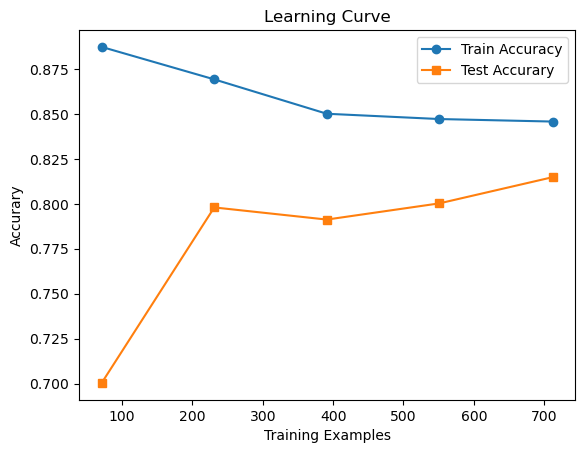

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores=learning_curve(model, inputs, target, cv=5, scoring='accuracy')

#Tính trung bình và độ lệch chuẩn
train_mean=np.mean(train_scores, axis=1)
test_mean=np.mean(test_scores, axis=1)

#Vẽ đồ thị
plt.plot(train_sizes, train_mean, label="Train Accuracy", marker='o')
plt.plot( train_sizes,test_mean, label="Test Accurary", marker='s')

plt.xlabel("Training Examples")
plt.ylabel("Accurary")
plt.title("Learning Curve")
plt.legend()
plt.show()

## Tự built model Decision Tree

### Tính Entropy

In [16]:
def entropy(y):
    classes, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return -np.sum(probabilities * np.log2(probabilities))

### Tính Infromation gain

In [17]:
def information_gain(X, y, feature_index):
    total_entropy = entropy(y)
    values, counts = np.unique(X[:, feature_index], return_counts=True)
    weighted_entropy = sum((counts[i] / sum(counts)) * entropy(y[X[:, feature_index] == values[i]]) for i in range(len(values)))
    return total_entropy - weighted_entropy

### Tìm đặc trưng tốt nhất

In [18]:
def best_split(X, y):
    best_feature = None
    best_gain = 0
    for feature_index in range(X.shape[1]):
        gain = information_gain(X, y, feature_index)
        if gain > best_gain:
            best_gain = gain
            best_feature = feature_index
    return best_feature if best_gain > 0 else None

### Cấu trúc của 1 nút trong Decision Tree

In [19]:
class DecisionTreeNode:
    def __init__(self, feature=None, value=None, left=None, right=None, prediction=None):
        self.feature = feature
        self.value = value
        self.left = left
        self.right = right
        self.prediction = prediction

### Xây dưng Decision Tree

In [20]:
def build_tree(X, y, depth=0, max_depth=7, min_samples_split=10):
    if len(y) == 0:
        return None
    
    if len(np.unique(y)) == 1 or len(y) < min_samples_split or depth >= max_depth:
        return DecisionTreeNode(prediction=np.bincount(y).argmax() if len(y) > 0 else 0)
    
    feature = best_split(X, y)
    if feature is None:
        return DecisionTreeNode(prediction=np.bincount(y).argmax() if len(y) > 0 else 0)
    
    median_value = np.median(X[:, feature])
    left_indices = X[:, feature] <= median_value
    right_indices = X[:, feature] > median_value
    
    if not np.any(left_indices) or not np.any(right_indices):
        return DecisionTreeNode(prediction=np.bincount(y).argmax())
    
    left_subtree = build_tree(X[left_indices], y[left_indices], depth + 1, max_depth, min_samples_split)
    right_subtree = build_tree(X[right_indices], y[right_indices], depth + 1, max_depth, min_samples_split)
    
    return DecisionTreeNode(feature=feature, value=median_value, left=left_subtree, right=right_subtree)

In [21]:
print(X_test.dtypes)  # Kiểm tra kiểu dữ liệu của từng cột
print(X_test[:5])     # Kiểm tra giá trị thực tế


Pclass      int64
Sex         int64
Age       float64
Fare      float64
dtype: object
     Pclass  Sex        Age     Fare
709       3    1  29.699118  15.2458
439       2    1  31.000000  10.5000
840       3    1  20.000000   7.9250
720       2    2   6.000000  33.0000
39        3    2  14.000000  11.2417


### Duyệt cây, dự đoán nhãn của x

In [22]:
def predict(tree, x):
    if tree is None or tree.prediction is not None:
        return tree.prediction if tree else 0
    return predict(tree.left, x) if x[tree.feature] <= tree.value else predict(tree.right, x)

### Tìm bộ max_depth và min_samples_split tốt nhất

In [23]:
best_acc = 0
best_params = (None, None)
param_grid = [(d, s) for d in range(3, 11) for s in range(5, 21, 5)]

for max_depth, min_samples_split in param_grid:
    #custom_tree = build_tree(X_train, Y_train, max_depth=max_depth, min_samples_split=min_samples_split)
    custom_tree = build_tree(X_train.values, Y_train, max_depth=max_depth, min_samples_split=min_samples_split)
    #Y_pred_test = np.array([predict(custom_tree, x) for x in X_test])
    Y_pred_test = np.array([predict(custom_tree, x) for x in X_test.to_numpy()])
    test_acc = np.mean(Y_pred_test == Y_test)
    
    if test_acc > best_acc:
        best_acc = test_acc
        best_params = (max_depth, min_samples_split)

### Huấn luyện vs model tốt nhất

In [24]:
#final_tree = build_tree(X_train, Y_train, max_depth=best_params[0], min_samples_split=best_params[1])
final_tree = build_tree(X_train.to_numpy(), Y_train, max_depth=best_params[0], min_samples_split=best_params[1])

#Y_pred_train = np.array([predict(final_tree, x) for x in X_train])
#Y_pred_test = np.array([predict(final_tree, x) for x in X_test])
Y_pred_train = np.array([predict(final_tree, x) for x in X_train.to_numpy()])
Y_pred_test = np.array([predict(final_tree, x) for x in X_test.to_numpy()])


train_acc = np.mean(Y_pred_train == Y_train)
test_acc = np.mean(Y_pred_test == Y_test)
print(f"Best max_depth: {best_params[0]}, Best min_samples_split: {best_params[1]}")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Best max_depth: 9, Best min_samples_split: 5
Train Accuracy: 0.8174
Test Accuracy: 0.7039


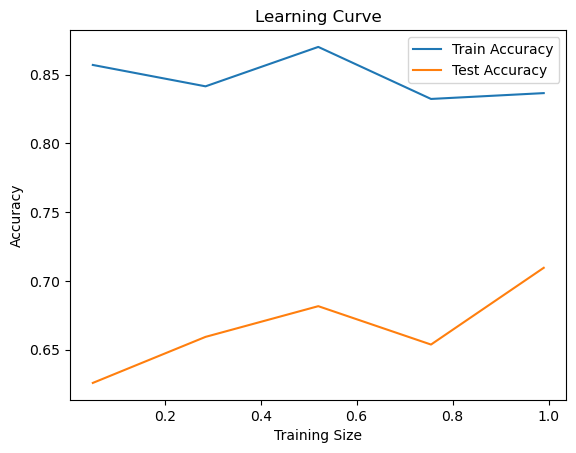

In [73]:
train_sizes = np.linspace(0.05, 0.99, 5) 

train_accs = []
test_accs = []
for size in train_sizes:
    X_train_subset, _, Y_train_subset, _ = train_test_split(X_train, Y_train, train_size=size, random_state=42)
    temp_tree = build_tree(X_train_subset.to_numpy(), Y_train_subset, max_depth=best_params[0], min_samples_split=best_params[1])
    Y_pred_train_subset = np.array([predict(temp_tree, x) for x in X_train_subset.to_numpy()])
    Y_pred_test_subset = np.array([predict(temp_tree, x) for x in X_test.to_numpy()])
    train_accs.append(np.mean(Y_pred_train_subset == Y_train_subset))
    test_accs.append(np.mean(Y_pred_test_subset == Y_test))
plt.figure()
plt.plot(train_sizes, train_accs, label='Train Accuracy')
plt.plot(train_sizes, test_accs, label='Test Accuracy')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve')
plt.show()